In [1]:
# Import libraries
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
# import data set

data = pd.read_csv('tested_molecules.csv')


In [3]:
# Generate descriptors for each molecule
descriptor_list = [d[0] for d in Descriptors._descList]
calculator = MoleculeDescriptors.MolecularDescriptorCalculator(descriptor_list)


# function to get the descriptor for each molecule in SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return calculator.CalcDescriptors(mol)
    return [None] * len(descriptor_list)

In [4]:
# SMILES contain the molecules, so apply the calculate_descriptors on SMILES
data['Descriptors'] = data['SMILES'].apply(compute_descriptors)
descriptors_df = pd.DataFrame(data['Descriptors'].tolist(), columns=descriptor_list)
data = pd.concat([data, descriptors_df], axis=1)

# Drop rows with NaN values
data.dropna(inplace=True)


In [5]:
print(descriptors_df)

      MaxEStateIndex  MinEStateIndex  MaxAbsEStateIndex  MinAbsEStateIndex  \
0           5.313889        0.120833           5.313889           0.120833   
1          11.238954       -0.366756          11.238954           0.225308   
2          11.090706       -0.049610          11.090706           0.049610   
3          11.892238       -0.457824          11.892238           0.076632   
4          11.693580       -0.498260          11.693580           0.012315   
...              ...             ...                ...                ...   
1111       12.955843       -0.290408          12.955843           0.016627   
1112       12.983770       -3.772852          12.983770           0.009487   
1113       10.579691        0.249681          10.579691           0.249681   
1114        4.812249        0.983396           4.812249           0.983396   
1115        4.773662        0.662326           4.773662           0.662326   

           qed    MolWt  HeavyAtomMolWt  ExactMolWt  NumValence

In [6]:
# standerdize data with standard scaler
#scaler = StandardScaler()
df_scaled = StandardScaler().fit_transform(descriptors_df)

In [7]:
# Apply PCA 
pca = PCA()
principal_components = pca.fit_transform(df_scaled)

# compute cumalative variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# get amount of component to cover 80% of variance
n_components_80_variance = (cumulative_variance >= 0.8).argmax() + 1  # index at 0 so add 1
print(f"Number of components to explain 80% variance: {n_components_80_variance}")

Number of components to explain 80% variance: 35


In [8]:
#get loadings
loadings = pca.components_

In [9]:
# make loading matrix
features = descriptors_df.columns
loading_matrix = pd.DataFrame(loadings, columns=features, index=[f'PC{i+1}' for i in range(len(loadings))])

In [10]:
# get absolute loading and print it
absolute_loadings = np.abs(loading_matrix).sum(axis=0).sort_values(ascending=False)
print("Sum of Absolute Loadings (Feature Importance):\n", absolute_loadings)

Sum of Absolute Loadings (Feature Importance):
 SMR_VSA10            10.818865
SlogP_VSA8           10.726949
SMR_VSA5             10.614510
SlogP_VSA1           10.517149
SlogP_VSA5           10.429701
                       ...    
fr_phos_acid          1.431506
fr_isothiocyan        1.411940
fr_term_acetylene     1.000641
fr_thiocyan           1.000641
fr_isocyan            1.000011
Length: 208, dtype: float64


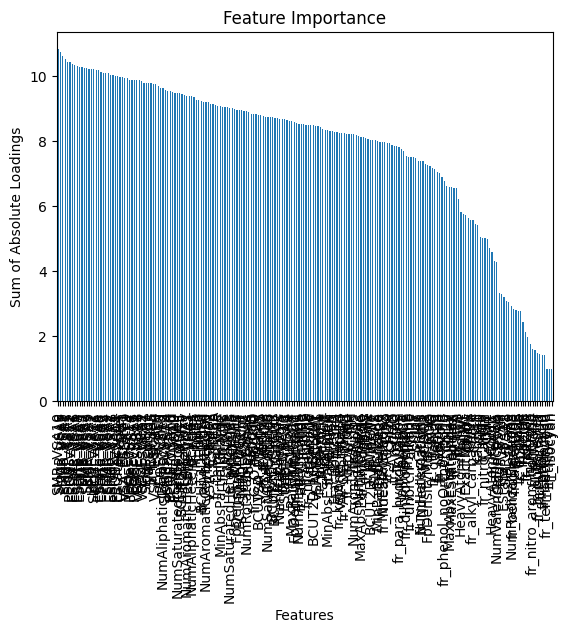

In [11]:
# visualize the different laodings. 
import matplotlib.pyplot as plt

absolute_loadings.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Sum of Absolute Loadings')
plt.xlabel('Features')
plt.show()



In [12]:
# threshold in %
threshold = 10
# get significant features
significant_features = absolute_loadings[absolute_loadings > threshold].index.tolist()
print("Significant features based on threshold:", significant_features)

Significant features based on threshold: ['SMR_VSA10', 'SlogP_VSA8', 'SMR_VSA5', 'SlogP_VSA1', 'SlogP_VSA5', 'PEOE_VSA12', 'EState_VSA1', 'SMR_VSA6', 'EState_VSA7', 'EState_VSA3', 'PEOE_VSA9', 'SMR_VSA7', 'SlogP_VSA3', 'SMR_VSA9', 'PEOE_VSA7', 'SlogP_VSA11', 'PEOE_VSA6', 'EState_VSA8', 'EState_VSA6', 'PEOE_VSA3', 'SMR_VSA4', 'SlogP_VSA2', 'EState_VSA2', 'SlogP_VSA6', 'PEOE_VSA11']


In [19]:
# prefrom logistic regression model

# Define features and target
X = descriptors_df[significant_features]
y1 = data['PKM2_inhibition']
y2 = data['ERK2_inhibition']
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
# Create a logistic regression model
model = LogisticRegression()

#scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model.fit(X_train_scaled, y_train)

# Get the predicted probabilities for the positive class
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

threshold = 1  # Example threshold
y_pred = (y_probs >= threshold).astype(int)


# Evaluation with confusion matrix and classification matrix
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.18303571428571427
Confusion Matrix:
 [[ 35 183]
 [  0   6]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.16      0.28       218
           1       0.03      1.00      0.06         6

    accuracy                           0.18       224
   macro avg       0.52      0.58      0.17       224
weighted avg       0.97      0.18      0.27       224



c:\Users\20212049\Documents\Jaar 3\Kwart 4\Advanced Programming\Group Assignment\.venv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Best Threshold=1.000000, G-Mean=0.785


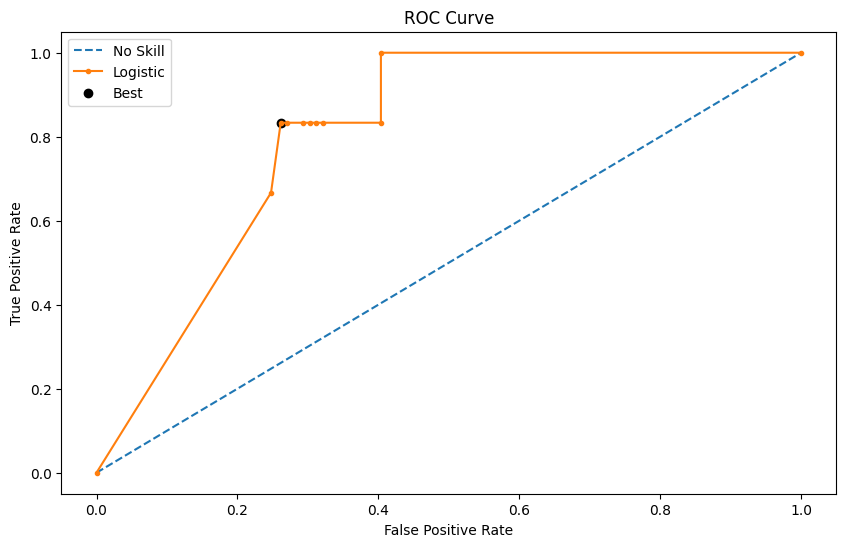

In [20]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_probs are the predicted probabilities of the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate the G-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

# Locate the index of the largest G-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
